In [54]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [55]:
# Define constants
IMG_SIZE = 128
NUM_CLASSES = 3
NUM_TRAIN = 1000
NUM_TEST = 100
CLASSES = ["circle", "square", "triangle"]
NUM_PER_CLASS = 100
SEED = 7
np.random.seed(SEED)


In [56]:
# drawing the shapes

def draw_circle(draw, bbox, fill): 
    draw.ellipse(bbox, fill=fill)

def draw_square(draw, bbox, fill): 
    draw.rectangle(bbox, fill=fill)

def draw_triangle(draw, bbox, fill):
    x0, y0, x1, y1 = bbox
    cx, cy = (x0 + x1) / 2, (y0 + y1) / 2
    pts = [(cx, y0), (x0, y1), (x1, y1)]
    draw.polygon(pts, fill=fill)

def random_color(): 
    return tuple(np.random.randint(30, 240, 3).tolist())

def random_bbox(img_size, min_rel=0.28, max_rel=0.75):
    s = np.random.uniform(min_rel, max_rel) * img_size
    w = h = int(s)
    x0 = np.random.randint(0, img_size - w)
    y0 = np.random.randint(0, img_size - h)
    return (x0, y0, x0 + w, y0 + h)


def add_light_noise(arr, sigma=6.0):
    # changing to float32 to avoid overflow then add gaussian noise
    noisy = arr.astype(np.float32) + np.random.normal(0,sigma,arr.shape)

    # clipping to avoid overflow and converting back to uint8
    return np.clip(noisy, 0, 255).astype(np.uint8)


In [57]:

# draw based on shape label
def draw_shape(shape_label):
    img = Image.new("RGB", (IMG_SIZE,IMG_SIZE), (255,255,255))
    draw = ImageDraw.Draw(img)

    bbox = random_bbox(IMG_SIZE)
    fill = random_color()
    
    if shape_label == "circle":
        draw_circle(draw, bbox, fill)
    elif shape_label == "square":
        draw_square(draw, bbox, fill)
    else:
        draw_triangle(draw, bbox, fill)

    arr = np.array(img, dtype = np.uint8)
    arr = add_light_noise(arr)
    return arr



In [58]:
def generate_dataset(num_per_classes=NUM_PER_CLASS):
    images = []
    labels = []
    for i in range(NUM_CLASSES):
        for j in range(num_per_classes):
            images.append(draw_shape(CLASSES[i]))
            labels.append(i)
    
    return np.stack(images), np.array(labels)



In [59]:
images, labels = generate_dataset()
print("images", images.shape)
print("labels", labels.shape)


images (300, 128, 128, 3)
labels (300,)


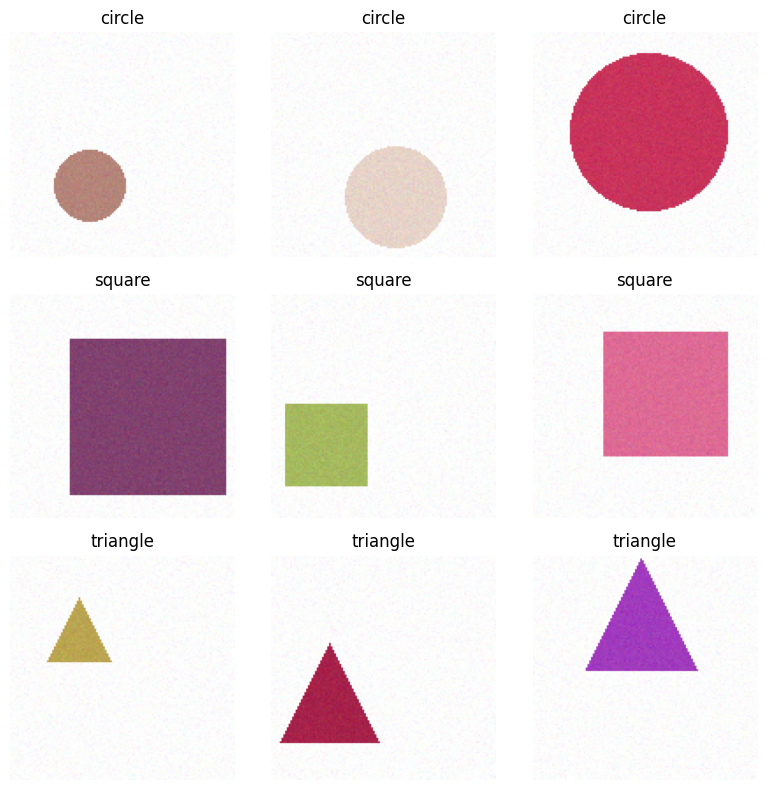

In [60]:
# Preview
def show_grid(samples, titles, nrow=3,ncol=3):
    plt.figure(figsize=(8,8))
    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(samples[i])
        plt.axis("off")

        if i < len(titles): 
            plt.title(titles[i])

    plt.tight_layout()
    plt.show()

# Pick 9 samples for preview
idxs=[]
for c in range(len(CLASSES)):
    idxs.extend(np.where(labels==c)[0][:3])

samples = images[idxs]
titles=[]
for c in range(len(CLASSES)): 
    titles += [CLASSES[c]] * 3

show_grid(samples, titles)

In [61]:
class ShapeDataset(Dataset):
    def __init__(self, images, labels, normalize=True):
        self.images = images
        self.labels = labels
        self.normalize = normalize

    def __len__(self): 
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.images[idx].astype(np.float32)/255.0
        # permute to (Channels, Height, Width) - PyTorch standard
        x = np.transpose(x, (2, 0, 1))
        y = int(self.labels[idx])

        return torch.tensor(x), torch.tensor(y)


In [62]:
dataset = ShapeDataset(images, labels)
n_total=len(dataset)
n_train=int(0.6*n_total)
n_val=int(0.2*n_total)
n_test=n_total-n_train-n_val
train_set,val_set,test_set=random_split(dataset,[n_train,n_val,n_test],
                                        generator=torch.Generator().manual_seed(SEED))


def make_loader(ds,bs=64,shuffle=False):
  return DataLoader(ds,batch_size=bs,shuffle=shuffle)

train_loader = make_loader(train_set, bs=64, shuffle=True)
val_loader   = make_loader(val_set, bs=64, shuffle=False)
test_loader  = make_loader(test_set, bs=64, shuffle=False)

print("Train/Val/Test sizes:", len(train_set), len(val_set), len(test_set))

Train/Val/Test sizes: 180 60 60


In [63]:
#  MLP

class MLP(nn.Module):
    def __init__(self, input_dim=IMG_SIZE*IMG_SIZE*3, hidden=252, num_classes=len(CLASSES)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
        
    def forward(self, x): 
         return self.net(x)


In [64]:

num_epochs = 10

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = 100. * correct / total

    return train_loss, train_acc

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)

            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total

    return val_loss, val_acc

In [65]:
def train_with_optimizer(optimizer_name, momentum=None, learning_rate=1e-3, num_epochs=10):
    model = MLP()
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        if momentum is None:
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        else:
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_loss:.4f}, "
            f"Train Acc: {train_acc:.2f}%")

        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Val Loss: {val_loss:.4f}, "
            f"Val Acc: {val_acc:.2f}%")

    test_loss, test_acc = validate(model, test_loader, criterion)

    print(f"Test Loss: {test_loss:.4f}, "
          f"Test Acc: {test_acc:.2f}%")

    return {
        "name": optimizer_name + " " + str(learning_rate) + " " + str(momentum),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "test_loss": test_loss,
        "test_acc": test_acc
    }




EXPERIMENT 1: SGD with LARGE learning rate (learning_rate=0.1)
Epoch 1/15, Train Loss: 180.5665, Train Acc: 35.00%
Epoch 1/15, Val Loss: 3.8552, Val Acc: 41.67%
Epoch 2/15, Train Loss: 2.6650, Train Acc: 29.44%
Epoch 2/15, Val Loss: 1.1504, Val Acc: 23.33%
Epoch 3/15, Train Loss: 1.1012, Train Acc: 38.89%
Epoch 3/15, Val Loss: 1.1049, Val Acc: 23.33%
Epoch 4/15, Train Loss: 1.0977, Train Acc: 38.89%
Epoch 4/15, Val Loss: 1.1070, Val Acc: 23.33%
Epoch 5/15, Train Loss: 1.0966, Train Acc: 38.89%
Epoch 5/15, Val Loss: 1.1089, Val Acc: 23.33%
Epoch 6/15, Train Loss: 1.0957, Train Acc: 38.89%
Epoch 6/15, Val Loss: 1.1110, Val Acc: 23.33%
Epoch 7/15, Train Loss: 1.0962, Train Acc: 38.89%
Epoch 7/15, Val Loss: 1.1125, Val Acc: 23.33%
Epoch 8/15, Train Loss: 1.0941, Train Acc: 38.89%
Epoch 8/15, Val Loss: 1.1143, Val Acc: 23.33%
Epoch 9/15, Train Loss: 1.0945, Train Acc: 38.89%
Epoch 9/15, Val Loss: 1.1160, Val Acc: 23.33%
Epoch 10/15, Train Loss: 1.0928, Train Acc: 38.89%
Epoch 10/15, Val Lo

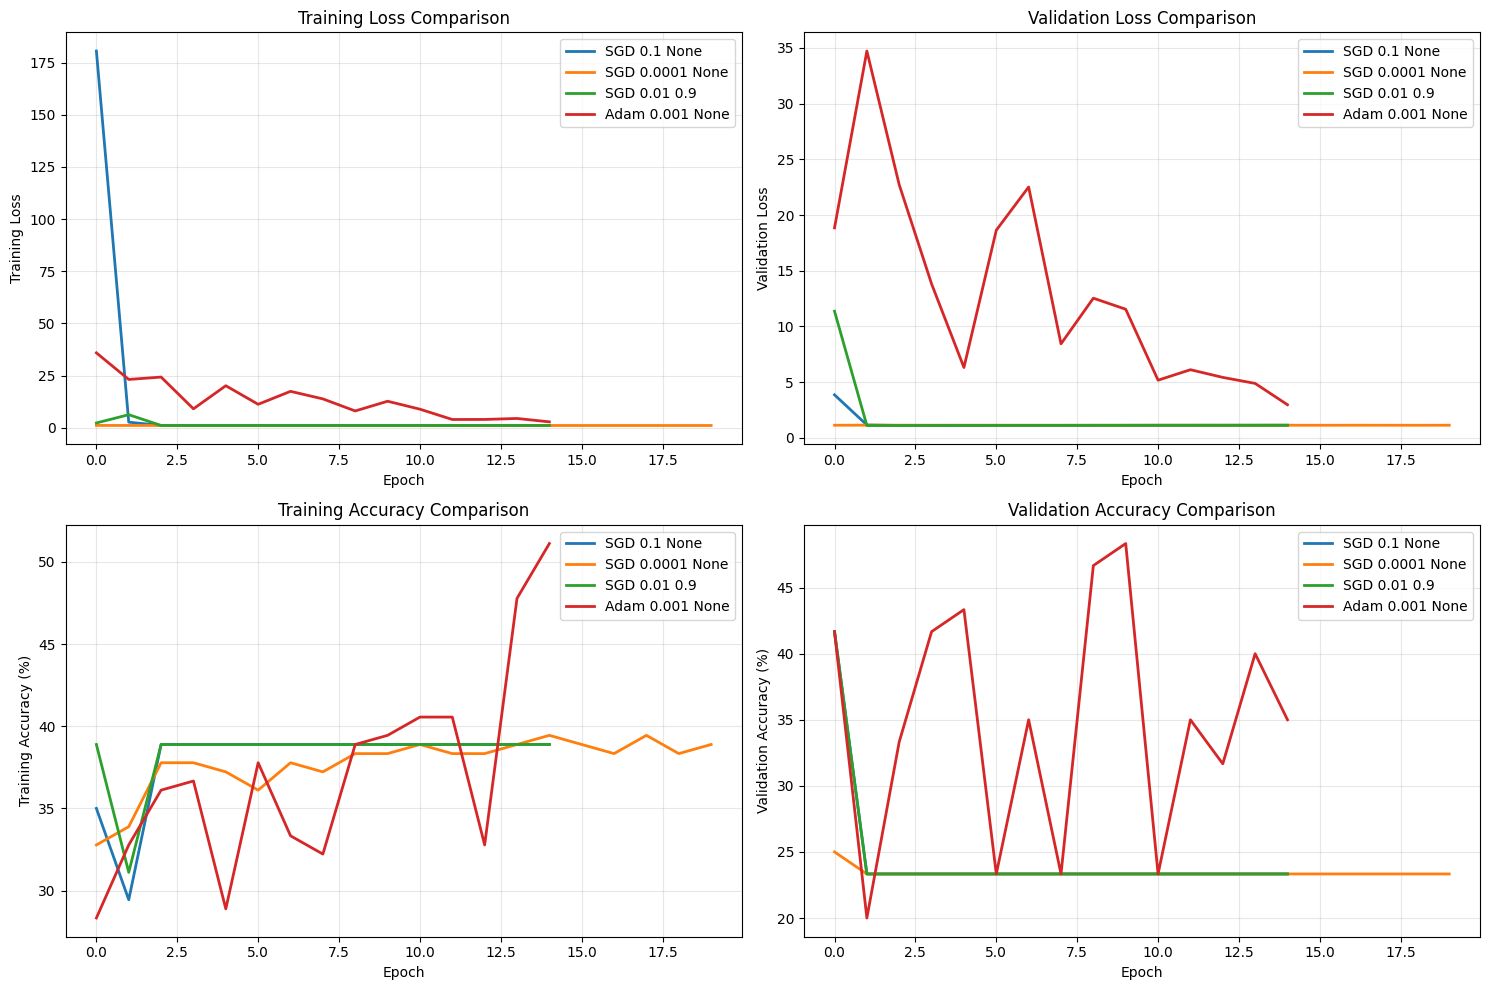


SUMMARY: Final Test Accuracies
SGD 0.1 None                             Test Acc: 26.67%
SGD 0.0001 None                          Test Acc: 28.33%
SGD 0.01 0.9                             Test Acc: 26.67%
Adam 0.001 None                          Test Acc: 35.00%


In [66]:

# Store results for comparison
all_results = []

# Experiment 1: SGD with large learning rate (should show instability)
print("\n" + "="*60)
print("EXPERIMENT 1: SGD with LARGE learning rate (learning_rate=0.1)")
print("="*60)
result1 = train_with_optimizer("SGD", learning_rate=0.1, num_epochs=15)
all_results.append(result1)

# Experiment 2: SGD with tiny learning rate (should show slow learning)
print("\n" + "="*60)
print("EXPERIMENT 2: SGD with TINY learning rate (learningrate=0.0001)")
print("="*60)
result2 = train_with_optimizer("SGD", learning_rate=0.0001, num_epochs=20)
all_results.append(result2)

# Experiment 3: SGD with momentum (should show smoother curves)
print("\n" + "="*60)
print("EXPERIMENT 3: SGD with MOMENTUM (learning_rate=0.01, momentum=0.9)")
print("="*60)
result3 = train_with_optimizer("SGD", learning_rate=0.01, momentum=0.9, num_epochs=15)
all_results.append(result3)

# Experiment 4: Adam (fast, stable learning)
print("\n" + "="*60)
print("EXPERIMENT 4: Adam (learning_rate=0.001)")
print("="*60)
result4 = train_with_optimizer("Adam", learning_rate=0.001, num_epochs=15)
all_results.append(result4)

# Comparison plots
print("\n" + "="*60)
print("COMPARISON PLOTS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss Comparison
ax = axes[0, 0]
for result in all_results:
    ax.plot(result['train_losses'], label=result['name'], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Validation Loss Comparison
ax = axes[0, 1]
for result in all_results:
    ax.plot(result['val_losses'], label=result['name'], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Training Accuracy Comparison
ax = axes[1, 0]
for result in all_results:
    ax.plot(result['train_accs'], label=result['name'], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Accuracy (%)')
ax.set_title('Training Accuracy Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Validation Accuracy Comparison
ax = axes[1, 1]
for result in all_results:
    ax.plot(result['val_accs'], label=result['name'], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Validation Accuracy Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*60)
print("SUMMARY: Final Test Accuracies")
print("="*60)
for result in all_results:
    print(f"{result['name']:40s} Test Acc: {result['test_acc']:.2f}%")


In [67]:
# Using CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * IMG_SIZE * IMG_SIZE, NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

    def get_features(self, x):
        features = []
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                x = layer(x)
                features.append(x)
        return features

cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_train_losses, cnn_train_accs, cnn_val_losses, cnn_val_accs = [], [], [], []


In [70]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(cnn_model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(cnn_model, val_loader, criterion)

    cnn_train_losses.append(train_loss)
    cnn_train_accs.append(train_acc)
    cnn_val_losses.append(val_loss)
    cnn_val_accs.append(val_acc)

cnn_test_loss, cnn_test_acc = validate(cnn_model, test_loader, criterion)
print(f"\nCNN Test Loss: {cnn_test_loss:.4f}, Test Accuracy: {cnn_test_acc:.2f}%")

# Compare MLP vs CNN
print("\n" + "="*60)
print("MLP vs CNN Comparison")
print("="*60)
# Get best MLP result (Adam)
best_mlp = result4
print(f"Best MLP (Adam): Test Acc = {best_mlp['test_acc']:.2f}%")
print(f"CNN: Test Acc = {cnn_test_acc:.2f}%")
print(f"Improvement: {cnn_test_acc - best_mlp['test_acc']:.2f}%")



CNN Test Loss: 1.1180, Test Accuracy: 36.67%

MLP vs CNN Comparison
Best MLP (Adam): Test Acc = 35.00%
CNN: Test Acc = 36.67%
Improvement: 1.67%



Visualizing CNN Feature Maps
torch.Size([1, 3, 128, 128])
shape of feat (64, 128, 128)
shape of feat (128, 128, 128)


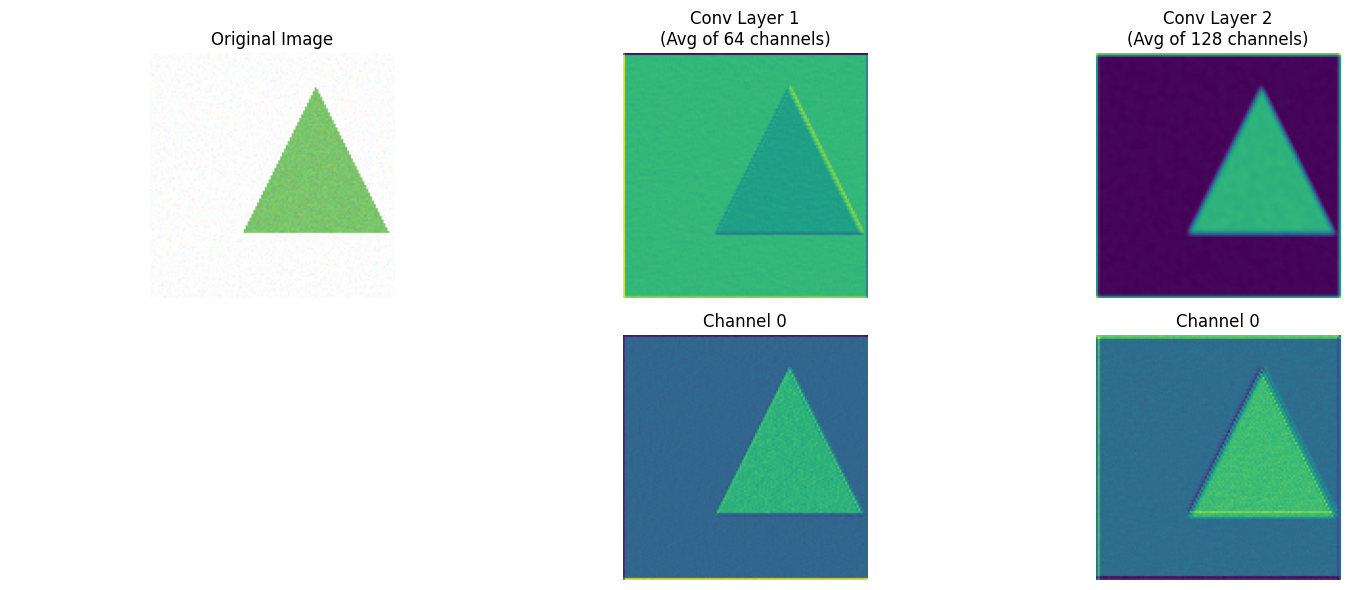

In [71]:
# Visualize feature maps
print("\n" + "="*60)
print("Visualizing CNN Feature Maps")
print("="*60)

cnn_model.eval()
with torch.no_grad():
    # Get one sample image
    sample_img, sample_label = next(iter(test_loader))
    sample_img = sample_img[0:1] # Take first image, add batch dimension
    print(sample_img.shape)

    # Get feature maps
    features = cnn_model.get_features(sample_img)

    # Visualize original and feature maps
    fig, axes = plt.subplots(2, len(features) + 1, figsize=(15, 6))

    # Show original image
    orig_img = sample_img[0].cpu().permute(1, 2, 0).numpy()
    axes[0, 0].imshow(orig_img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')

    # Show feature maps from each conv layer
    for i, feat_map in enumerate(features):
        # Take first 8 channels and visualize
        feat = feat_map[0].cpu().numpy()  # Remove batch dimension
        print('shape of feat', feat.shape)
        n_channels = min(8, feat.shape[0])

        # Show average of all channels
        avg_feat = feat.mean(0)
        axes[0, i+1].imshow(avg_feat, cmap='viridis')
        axes[0, i+1].set_title(f'Conv Layer {i+1}\n(Avg of {feat.shape[0]} channels)')
        axes[0, i+1].axis('off')

        # Show first channel
        axes[1, i+1].imshow(feat[0], cmap='viridis')
        axes[1, i+1].set_title(f'Channel 0')
        axes[1, i+1].axis('off')

    plt.tight_layout()
    plt.show()

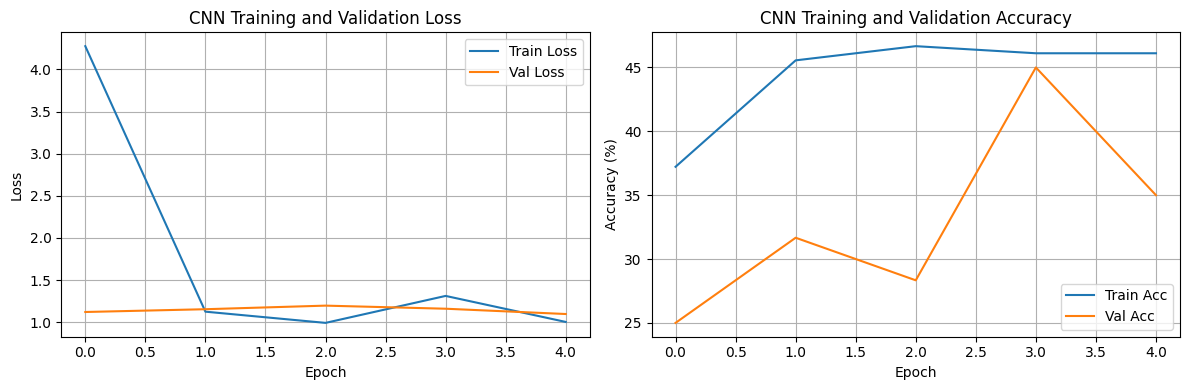

In [72]:
# Plot CNN training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cnn_train_accs, label='Train Acc')
plt.plot(cnn_val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CNN Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()